In [9]:
!pip install transformers
!pip install datasets
!pip install evaluate

import transformers
from transformers import AutoTokenizer
from transformers import TrainingArguments, Trainer
from transformers import AutoModelForSequenceClassification
import pandas as pd
import numpy as np
import torch
import file_manager

In [10]:
classifier_settings = file_manager.get_config(section="bert")
classifier_settings["train_dataset"]

'./csv_data/train.csv'

In [11]:
df_train = pd.read_csv(classifier_settings["train_dataset"])
df_test = pd.read_csv(classifier_settings["test_dataset"])

X = list(df_train["text"])
X_test = list(df_test["text"])
Y = list(df_train["label"])
Y_test = list(df_test["label"])

In [12]:
tokenizer: transformers.models.bert.tokenization_bert_fast.BertTokenizerFast = AutoTokenizer.from_pretrained("bert-base-german-cased")

X_train_tokenized = tokenizer(X, padding=True, truncation=True)
X_test_tokenized = tokenizer(X_test, padding=True, truncation=True)

In [13]:
# Create torch dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])


train_dataset = Dataset(X_train_tokenized, Y)
val_dataset = Dataset(X_test_tokenized, Y_test)

In [14]:
model = AutoModelForSequenceClassification.from_pretrained("bert-base-german-cased", num_labels=classifier_settings["num_labels"])
model = model.to('cuda')

Some weights of the model checkpoint at bert-base-german-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoi

In [15]:
from datasets import load_metric
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

def compute_metrics(p):
    print(type(p))
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred, average='macro')
    precision = precision_score(y_true=labels, y_pred=pred, average='macro')
    f1 = f1_score(y_true=labels, y_pred=pred, average='macro')

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [16]:
torch.cuda.empty_cache()
args = TrainingArguments(
    output_dir="output",
    num_train_epochs=classifier_settings["epochs"],
    per_device_train_batch_size=classifier_settings["batch_size"],
    evaluation_strategy="epoch",
    learning_rate=classifier_settings["learning_rate"]
)

class CustomTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # compute custom loss (suppose 3 labels with different weights)
        loss_fct = torch.nn.CrossEntropyLoss(weight=torch.tensor([1.0, 1.0, 1.0]).to('cuda'))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

trainer = CustomTrainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)
trainer.train()

C:\Users\Wojtek\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 17440
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1090
  Number of trainable parameters = 109083651
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


OutOfMemoryError: CUDA out of memory. Tried to allocate 24.00 MiB (GPU 0; 6.00 GiB total capacity; 5.25 GiB already allocated; 0 bytes free; 5.31 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [26]:
trainer.save_model(classifier_settings["model_name"])

Saving model checkpoint to balanced-1epochs
Configuration saved in balanced-1epochs/config.json
Model weights saved in balanced-1epochs/pytorch_model.bin


In [27]:
### Testing model ###
model_2 = AutoModelForSequenceClassification.from_pretrained(classifier_settings["model_name"])
model_2.to('cuda')

loading configuration file balanced-1epochs/config.json
Model config BertConfig {
  "_name_or_path": "balanced-1epochs",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.25.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30000
}

loading weights file balanced-1epochs/pytorch_model.bin
All model checkpoi

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [29]:
predictions_train = trainer.predict(train_dataset)
predictions_test = trainer.predict(val_dataset)
predictions_train = predictions_train[0].argmax(axis=1)
predictions_test = predictions_test[0].argmax(axis=1)

***** Running Prediction *****
  Num examples = 5726
  Batch size = 8


<class 'transformers.trainer_utils.EvalPrediction'>


***** Running Prediction *****
  Num examples = 4343
  Batch size = 8


<class 'transformers.trainer_utils.EvalPrediction'>


REPORT TRAIN
              precision    recall  f1-score   support

    positive     0.6401    0.8418    0.7272      2054
     neutral     0.7066    0.5261    0.6031      1895
    negative     0.8166    0.7417    0.7774      1777

    accuracy                         0.7063      5726
   macro avg     0.7211    0.7032    0.7026      5726
weighted avg     0.7169    0.7063    0.7017      5726



[]

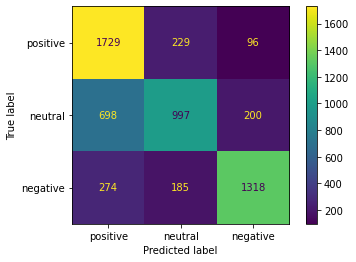

In [30]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt


names = ["positive", "neutral", "negative"]

print("REPORT TRAIN")
print(classification_report(Y, predictions_train, target_names=names, digits=4))
matrix = confusion_matrix(Y, predictions_train)

disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=names)
disp.plot()
plt.plot()

REPORT TEST
              precision    recall  f1-score   support

    positive     0.7338    0.5214    0.6097      3124
     neutral     0.1454    0.2677    0.1885       635
    negative     0.1667    0.2723    0.2068       584

    accuracy                         0.4508      4343
   macro avg     0.3486    0.3538    0.3350      4343
weighted avg     0.5715    0.4508    0.4939      4343



[]

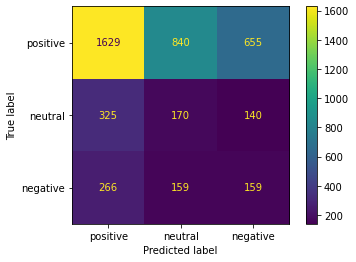

In [31]:
print("REPORT TEST")
print(classification_report(Y_test, predictions_test, target_names=names, digits=4))
matrix = confusion_matrix(Y_test, predictions_test)

disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=names)
disp.plot()
plt.plot()